In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import numpy as np
from tqdm import tqdm
import os
import time
import tensorflow as tf

## load data + preprocessing

In [ ]:
# let's define height and width for images
image_height = 180
image_width = 180

# let's set the batch size equal to 32
batch_size=32

In [ ]:
path= "Front_dataset_v2/data/train/data"
# upload the dataset from my drive folder
dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(image_height, image_width),
    batch_size= 32,
    label_mode='categorical',
    seed=42
)

Found 2037 files belonging to 5 classes.


In [ ]:
path= "Front_dataset_v2/data/test/data"
train_dataset = dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(image_height, image_width),
    batch_size=32,
    label_mode='categorical',
    seed=42  # Add the same seed for reproducibility
)

Found 358 files belonging to 5 classes.


2023-09-12 16:15:16.032103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2037]
	 [[{{node Placeholder/_4}}]]
2023-09-12 16:15:16.032284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2037]
	 [[{{node Placeholder/_4}}]]


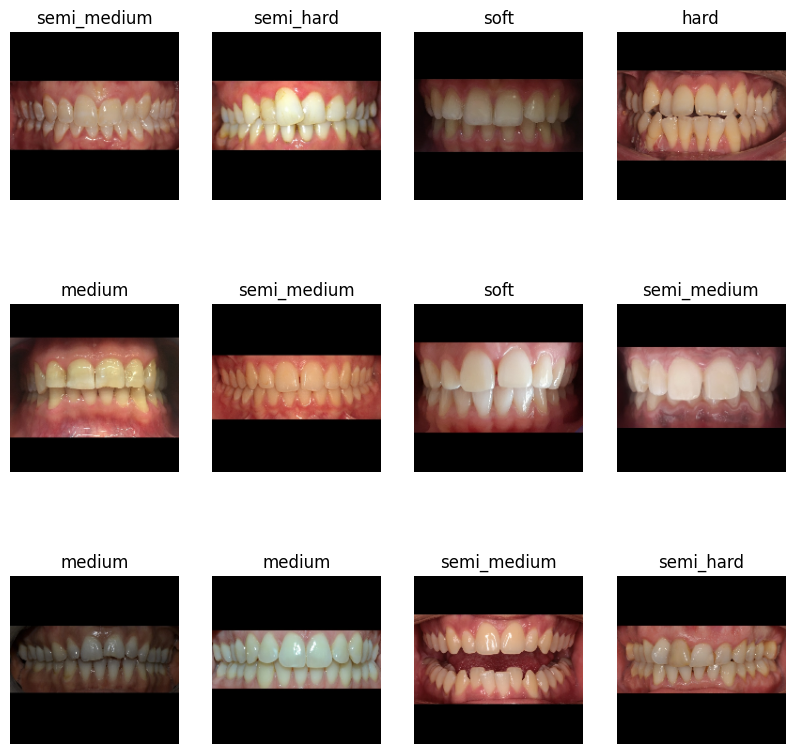

In [ ]:
# let's plot a sample of images from my data

label_names = sorted(os.listdir(path))
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        label_index = np.argmax(label_batch[i])
        plt.title(label_names[label_index])
        plt.axis('off')

 Data Augmentation procedures:
 I chose to practice some data augmentation techniques to improve the training of my models. First, i rescaled the image pixels to be in the [0,1] range. Then I applied some trasformations (Rotations, Flips, Zooms and Contrast) to make my models more invariant to transormations.
 I followed the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=it#overview) as guide in this part.

In [ ]:
# map the pixel values into [0,1] space
data_rescalation =  tf.keras.Sequential([
  layers.Rescaling(1./255)
])

# apply random transformations to make the network more robust to transformations
data_augmentation = tf.keras.Sequential([

    layers.RandomRotation(0.1),
    #layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(height_factor = (0.15)),
    layers.RandomContrast(0.15)
  ])

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def preparation(ds, augment=False):

  # Rescale all datasets.
  ds = ds.map(lambda x, y: (data_rescalation(x), y),
              num_parallel_calls=AUTOTUNE)


  # data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# let's apply the mods to the images inside my datasets
train_dataset_p = preparation(train_dataset, False)
# create a version augumented
train_dataset_p_aug = preparation(train_dataset, True)

validation_dataset_p = preparation(validation_dataset,False)


In [ ]:
# Save train datasets
tf.data.experimental.save(train_dataset_p, 'train_dataset_p')
tf.data.experimental.save(train_dataset_p_aug, 'train_dataset_p_aug')

# Save validation dataset
tf.data.experimental.save(validation_dataset_p, 'validation_dataset_p')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


2023-09-12 16:17:06.137925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2037]
	 [[{{node Placeholder/_4}}]]
2023-09-12 16:17:06.138158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2037]
	 [[{{node Placeholder/_4}}]]
2023-09-12 16:17:06.759845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2037]
	

In [ ]:
# Load train datasets
train_dataset_p = tf.data.experimental.load('train_dataset_p')

train_dataset_p_aug = tf.data.experimental.load('train_dataset_p_aug')

# Load validation dataset
validation_dataset_p = tf.data.experimental.load('validation_dataset_p')

In [ ]:
def accuarcy_free_double_preds(y_true,preds):

    top_indices = tf.argsort(preds, axis=1, direction='DESCENDING')[:, :2]

    y_true_labels = tf.argmax(y_true, axis=1)

    top_indices = tf.cast(top_indices, tf.int32)
    y_true_labels = tf.cast(y_true_labels, tf.int32)
    # Creating a mask for correct predictions
    correct_mask = tf.reduce_any(tf.equal(top_indices, tf.expand_dims(y_true_labels, axis=-1)), axis=1)

    # Counting the number of correct instances
    num_correct_predictions = tf.reduce_sum(tf.cast(correct_mask, tf.float32))

    # Calculating accuracy
    accuracy = num_correct_predictions / y_true.shape[0]

    return accuracy



def accuracy_adj_double_preds(y_true, preds):
    # Find the index of the maximum prediction for each instance
    #print(preds)
    max_indices = tf.argmax(preds, axis=1)
    y_true_indices = tf.argmax(y_true, axis=1)
    y_true_indices = tf.cast(y_true_indices, tf.int32)
    # Calculate the number of classes
    num_classes = preds.shape[1]

    # Calculate the indices of the adjacent positions
    adj_indices_left = tf.clip_by_value(max_indices - 1, 0, num_classes - 1)
    adj_indices_right = tf.clip_by_value(max_indices + 1, 0, num_classes - 1)
    adj_indices_left = tf.where(max_indices == 0, tf.constant(1, dtype=tf.int64), adj_indices_left)
    adj_indices_right = tf.where(max_indices == 4, tf.constant(3, dtype=tf.int64), adj_indices_right)



    adj_indices_left = tf.cast(adj_indices_left, tf.int32)
    adj_indices_right = tf.cast(adj_indices_right, tf.int32)

    # Get the probabilities corresponding to adj_indices_left and adj_indices_right
    left_probabilities = tf.gather_nd(preds, tf.stack((tf.range(tf.shape(adj_indices_left)[0], dtype=tf.int32), adj_indices_left), axis=1))
    right_probabilities = tf.gather_nd(preds, tf.stack((tf.range(tf.shape(adj_indices_right)[0], dtype=tf.int32), adj_indices_right), axis=1))

    # Compare the probabilities and determine which one is higher
    comparisons = tf.math.greater(left_probabilities, right_probabilities)


    selected_indices = tf.where(comparisons, adj_indices_left, adj_indices_right)
    #print(selected_indices)
    correct_selected = tf.reduce_sum(tf.cast(tf.equal(selected_indices, y_true_indices), tf.float32))
    #print(correct_selected)
    # Calcola il numero di predizioni corrette tra max_indices e y_true
    max_indices = tf.cast(max_indices, tf.int32)
    #print(max_indices)
    correct_max = tf.reduce_sum(tf.cast(tf.equal(max_indices, y_true_indices), tf.float32))
    #print(correct_max)
    # Somma il numero di predizioni corrette tra le due condizioni
    total_correct = correct_selected + correct_max

    # Calcola l'accuratezza dividendo per il numero di campioni in y_true
    accu = total_correct / tf.cast(tf.shape(y_true)[0], tf.float32)


    return accu



def mean_list(lista):
  """ it computes the mean of a list
  """
  mean = sum(lista) / len(lista)
  return mean


# Model 1: CNN

I decided to use a Convolutional neural network with 4 convolutional block, a global average pooling layer and a classification block. Each convolutional block is made in this way:

* 2D convolutional layer
* Batch Normalization
* Relu as activaction function
* Max pooling layer


In [ ]:
class Cnn_SL(tf.keras.Model):

    def __init__(self, num_classes=5):

        super().__init__()

        # 1 conv block
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.pool1 = layers.MaxPool2D(2)


        # 2 conv block
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.pool2 = layers.MaxPool2D(2)


        # 3 conv block
        self.conv3 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm3 = layers.BatchNormalization()
        self.act3 = layers.ReLU()
        self.pool3 = layers.MaxPool2D(2)


        # 4 conv block
        self.conv4 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm4 = layers.BatchNormalization()
        self.act4 = layers.ReLU()
        self.pool4 = layers.MaxPool2D(2)

        # Global Pooling
        self.globalpooling = layers.GlobalAvgPool2D()

        # Flatten
        self.flatten = tf.keras.layers.Flatten()

        # Fc 1
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(128, activation='relu')
        self.dense3 = layers.Dense(64, activation='relu')
        self.droput1 = layers.Dropout(0.3)

        # Fc 2
        self.dense4 = layers.Dense(32)
        self.droput2 = layers.Dropout(0.3)



        # Classification
        self.classifier = layers.Dense(num_classes, activation='softmax')



    def call(self, inputs, training=False):


      if training:

        #################
        # TRAINING TIME #
        #################

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)


        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)


        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense4(x)
        x = self.droput2(x)

        # Classification
        output = self.classifier(x)


        return output


      else:

        ##################
        # INFERENCE TIME #
        ##################

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)




        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)



        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense4(x)
        x = self.droput2(x)

        # Classification
        output = self.classifier(x)


        return output

In [ ]:
model = Cnn_SL(num_classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
accuracy_metrics = tf.keras.metrics.Accuracy()
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc = 0
stored_model = None

In [ ]:
# outputs of train time
train_Total_loss_epochs = []

train_accuracy_epochs = []
train_free_double_preds_acc =[]
train_dj_double_preds_acc = []

# outputs of validation time


val_loss_epochs = []
val_accuracy_epochs = []
val_free_double_preds_acc =[]
val_dj_double_preds_acc = []

epochs = 30
start_time = time.time()



for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    ###############################
    ###########  TRAIN  ###########
    ###############################

    # empty lists to store the intermediate results
    total_loss_epoch =[]
    free_double_preds_intra_epochs =[]
    adj_double_preds_intra_epochs = []

    for  x_train, y_train in train_dataset_p:

        with tf.GradientTape() as tape:

            # Run the forward pass of the layer
            predictions= model(x_train, training=True)
            #print(predictions)

            # loss
            l_ =  tf.keras.losses.CategoricalCrossentropy()
            loss_ = l_(y_train, predictions)

            # store intermediate results
            total_loss_epoch.append(loss_.numpy())

        # optimization
        grads = tape.gradient(loss_, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # classical accuracy
        accuracy_metrics.update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions, axis=1))

        # free double predictions accuracy
        free_double_preds = accuarcy_free_double_preds(y_train, predictions)
        free_double_preds_intra_epochs.append(free_double_preds)

        # adjacent double predictions accuracy
        adj_double_preds = accuracy_adj_double_preds(y_train, predictions)
        adj_double_preds_intra_epochs.append(adj_double_preds)

    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f " %  (mean_list(total_loss_epoch)))
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (float(accuracy_metrics.result()), mean_list(free_double_preds_intra_epochs), mean_list(adj_double_preds_intra_epochs)))


    # store the total loss
    train_Total_loss_epochs.append(mean_list(total_loss_epoch))

    # store the accuracy
    train_accuracy_epochs.append(float(accuracy_metrics.result()))
    train_free_double_preds_acc.append(mean_list(free_double_preds_intra_epochs))
    train_dj_double_preds_acc.append(mean_list(adj_double_preds_intra_epochs))


    # Reset training metrics at the end of each epoch
    accuracy_metrics.reset_states()

    ####################################
    ###########  VALIDATION  ###########
    ####################################
    val_free_double_preds_intra_epochs =[]
    val_adj_double_preds_intra_epochs = []

    for  x_val, y_val in validation_dataset_p:
      val_predictions = model(x_val, training = False)

      # accuracy
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))
      current_val_accuracy = val_accuracy.result().numpy()

      # free double predictions accuracy
      val_free_double_preds = accuarcy_free_double_preds(y_val, val_predictions)
      val_free_double_preds_intra_epochs.append(val_free_double_preds)

        # adjacent double predictions accuracy
      val_adj_double_preds = accuracy_adj_double_preds(y_val, val_predictions)
      val_adj_double_preds_intra_epochs.append(val_adj_double_preds)

    print("###################################  VALIDATION  ###################################")
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (current_val_accuracy, mean_list(val_free_double_preds_intra_epochs), mean_list(val_adj_double_preds_intra_epochs)))

    val_free_double_preds_acc.append(mean_list(val_free_double_preds_intra_epochs))
    val_dj_double_preds_acc.append(mean_list(val_adj_double_preds_intra_epochs))
    val_accuracy_epochs.append(current_val_accuracy)


    # update for the best model according to val accuracy
    if(current_val_accuracy >= stored_val_acc):
     stored_val_acc = current_val_accuracy
     stored_model = model

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))


Epoch 1/30
###################################  TRAIN  ###################################
Total_Loss: 1.5683 
Accuracy: 0.2523 Accuracy_free_double: 0.4967 Accuracy_adj_double: 0.5092
###################################  VALIDATION  ###################################
Accuracy: 0.2849 Accuracy_free_double: 0.5608 Accuracy_adj_double: 0.5608

Epoch 2/30
###################################  TRAIN  ###################################
Total_Loss: 1.5325 
Accuracy: 0.2739 Accuracy_free_double: 0.5167 Accuracy_adj_double: 0.5289
###################################  VALIDATION  ###################################
Accuracy: 0.2905 Accuracy_free_double: 0.5634 Accuracy_adj_double: 0.5608

Epoch 3/30
###################################  TRAIN  ###################################
Total_Loss: 1.5260 
Accuracy: 0.2882 Accuracy_free_double: 0.5353 Accuracy_adj_double: 0.5431
###################################  VALIDATION  ###################################
Accuracy: 0.2905 Accuracy_free_double: 

In [ ]:
# store the best model
stored_model.save_weights('Front_dataset/Cnn')

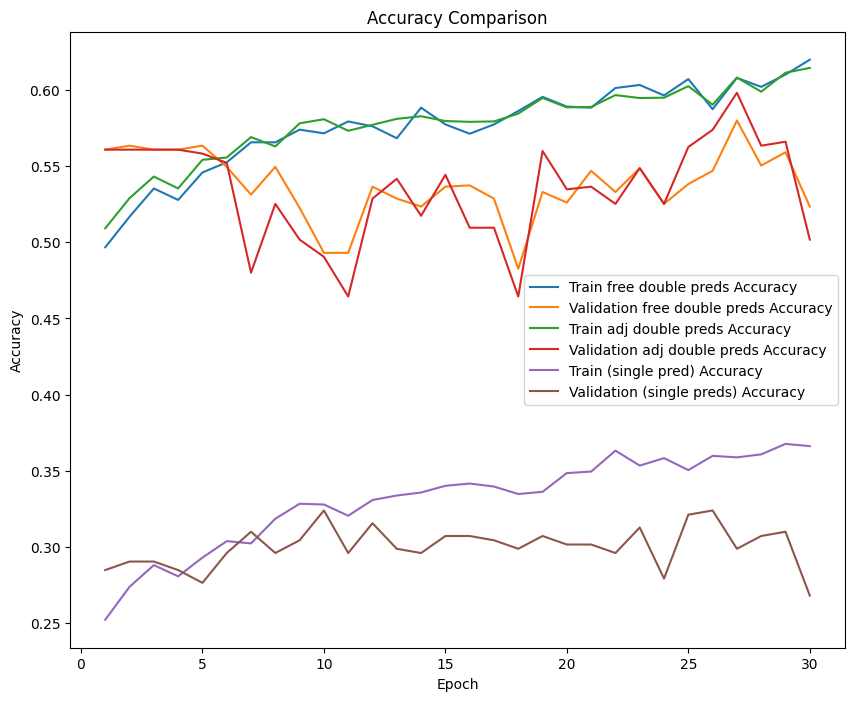

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_free_double_preds_acc, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_free_double_preds_acc, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_dj_double_preds_acc, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_dj_double_preds_acc, label='Validation adj double preds Accuracy')

plt.plot(range(1, 31), train_accuracy_epochs, label='Train (single pred) Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs, label='Validation (single preds) Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

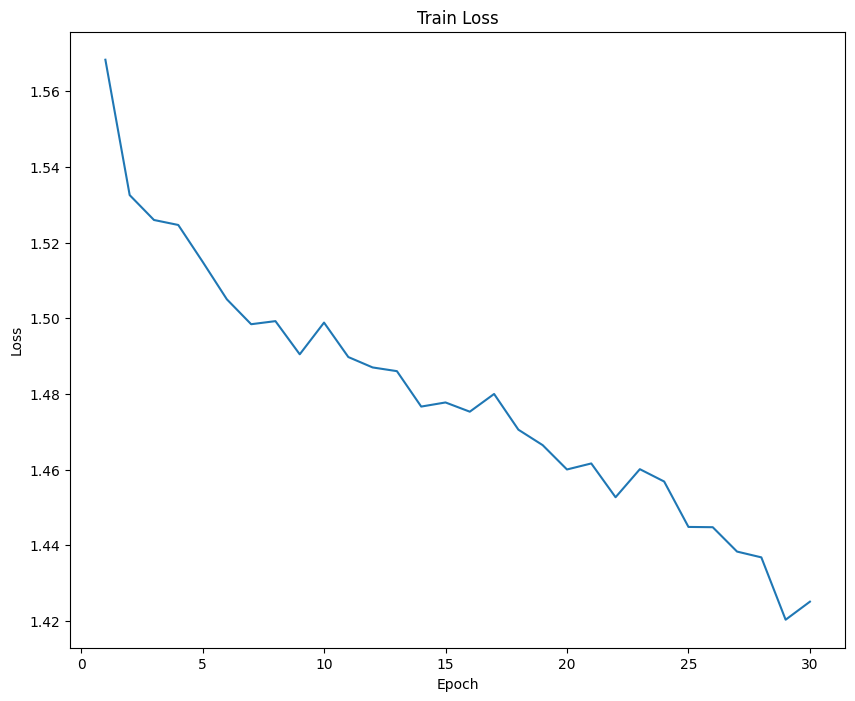

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_Total_loss_epochs)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')


plt.show()

# Model 2: CNN (Data augmentation)

In [ ]:
model = Cnn_SL(num_classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
accuracy_metrics = tf.keras.metrics.Accuracy()
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc = 0
stored_model = None

In [ ]:
# outputs of train time
train_Total_loss_epochs = []

train_accuracy_epochs = []
train_free_double_preds_acc =[]
train_dj_double_preds_acc = []

# outputs of validation time


val_loss_epochs = []
val_accuracy_epochs = []
val_free_double_preds_acc =[]
val_dj_double_preds_acc = []

epochs = 30
start_time = time.time()



for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    ###############################
    ###########  TRAIN  ###########
    ###############################

    # empty lists to store the intermediate results
    total_loss_epoch =[]
    free_double_preds_intra_epochs =[]
    adj_double_preds_intra_epochs = []

    for  x_train, y_train in train_dataset_p_aug:

        with tf.GradientTape() as tape:

            # Run the forward pass of the layer
            predictions= model(x_train, training=True)
            #print(predictions)

            # loss
            l_ =  tf.keras.losses.CategoricalCrossentropy()
            loss_ = l_(y_train, predictions)

            # store intermediate results
            total_loss_epoch.append(loss_.numpy())

        # optimization
        grads = tape.gradient(loss_, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # classical accuracy
        accuracy_metrics.update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions, axis=1))

        # free double predictions accuracy
        free_double_preds = accuarcy_free_double_preds(y_train, predictions)
        free_double_preds_intra_epochs.append(free_double_preds)

        # adjacent double predictions accuracy
        adj_double_preds = accuracy_adj_double_preds(y_train, predictions)
        adj_double_preds_intra_epochs.append(adj_double_preds)

    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f " %  (mean_list(total_loss_epoch)))
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (float(accuracy_metrics.result()), mean_list(free_double_preds_intra_epochs), mean_list(adj_double_preds_intra_epochs)))


    # store the total loss
    train_Total_loss_epochs.append(mean_list(total_loss_epoch))

    # store the accuracy
    train_accuracy_epochs.append(float(accuracy_metrics.result()))
    train_free_double_preds_acc.append(mean_list(free_double_preds_intra_epochs))
    train_dj_double_preds_acc.append(mean_list(adj_double_preds_intra_epochs))


    # Reset training metrics at the end of each epoch
    accuracy_metrics.reset_states()

    ####################################
    ###########  VALIDATION  ###########
    ####################################
    val_free_double_preds_intra_epochs =[]
    val_adj_double_preds_intra_epochs = []

    for  x_val, y_val in validation_dataset_p:
      val_predictions = model(x_val, training = False)

      # accuracy
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))
      current_val_accuracy = val_accuracy.result().numpy()

      # free double predictions accuracy
      val_free_double_preds = accuarcy_free_double_preds(y_val, val_predictions)
      val_free_double_preds_intra_epochs.append(val_free_double_preds)

        # adjacent double predictions accuracy
      val_adj_double_preds = accuracy_adj_double_preds(y_val, val_predictions)
      val_adj_double_preds_intra_epochs.append(val_adj_double_preds)

    print("###################################  VALIDATION  ###################################")
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (current_val_accuracy, mean_list(val_free_double_preds_intra_epochs), mean_list(val_adj_double_preds_intra_epochs)))

    val_free_double_preds_acc.append(mean_list(val_free_double_preds_intra_epochs))
    val_dj_double_preds_acc.append(mean_list(val_adj_double_preds_intra_epochs))
    val_accuracy_epochs.append(current_val_accuracy)


    # update for the best model according to val accuracy
    if(current_val_accuracy >= stored_val_acc):
     stored_val_acc = current_val_accuracy
     stored_model = model

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))





Epoch 1/30
###################################  TRAIN  ###################################
Total_Loss: 1.5729 
Accuracy: 0.2479 Accuracy_free_double: 0.5023 Accuracy_adj_double: 0.5050
###################################  VALIDATION  ###################################
Accuracy: 0.2626 Accuracy_free_double: 0.5608 Accuracy_adj_double: 0.5608

Epoch 2/30
###################################  TRAIN  ###################################
Total_Loss: 1.5292 
Accuracy: 0.2769 Accuracy_free_double: 0.5177 Accuracy_adj_double: 0.5260
###################################  VALIDATION  ###################################
Accuracy: 0.2849 Accuracy_free_double: 0.5608 Accuracy_adj_double: 0.5608

Epoch 3/30
###################################  TRAIN  ###################################
Total_Loss: 1.5181 
Accuracy: 0.2985 Accuracy_free_double: 0.5221 Accuracy_adj_double: 0.5333
###################################  VALIDATION  ###################################
Accuracy: 0.2626 Accuracy_free_double: 

In [ ]:
# store the best model
stored_model.save_weights('Front_dataset/Cnn_aug')

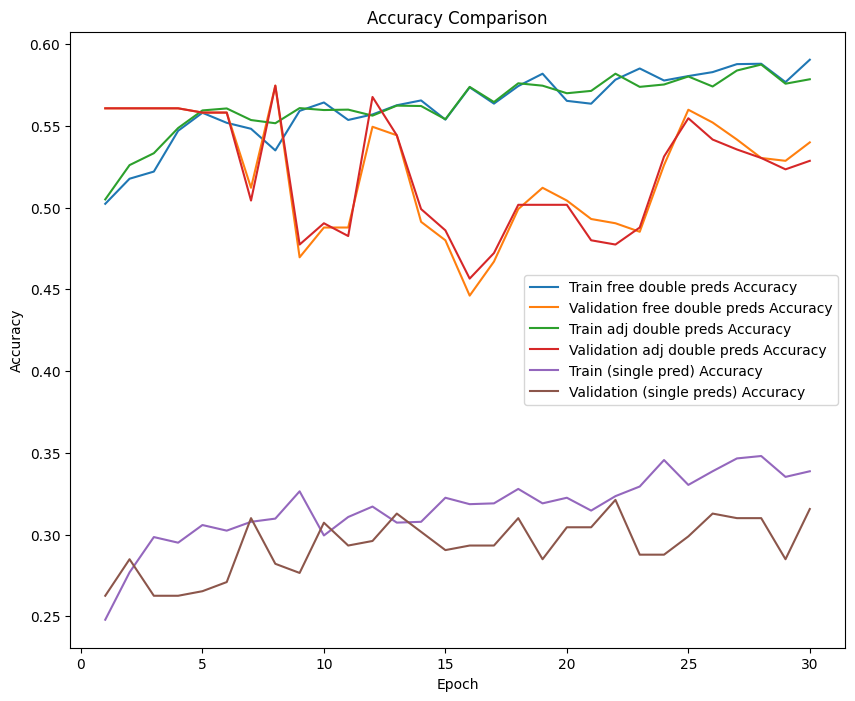

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_free_double_preds_acc, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_free_double_preds_acc, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_dj_double_preds_acc, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_dj_double_preds_acc, label='Validation adj double preds Accuracy')

plt.plot(range(1, 31), train_accuracy_epochs, label='Train (single pred) Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs, label='Validation (single preds) Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

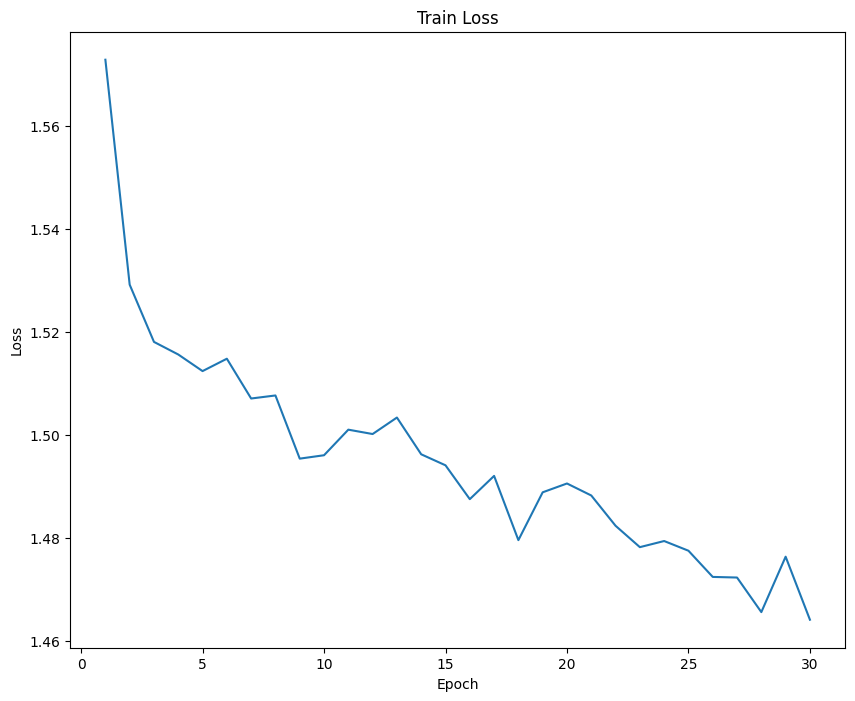

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_Total_loss_epochs)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')


plt.show()

# Model 3: CNN + Modularity (Early exit)


I have taken the architecture of the convolutional network defined in the previous point, in which however I have added two early exit blocks. the first inserted after the second convolutional block and the other after the third convolutional block. Each of the early exit blocks I have defined is designed as follows:

* FC layer with 256 units
* Dropout(0.3)
* FC layer with 3 units (the number of all the possible exits)
I also want to  balance the exits. To do this I insterted also the exit selector block. this was defined by me by combining 3 fully connected layers and at the end a final classification layer. This block produces as output, for each input image, a probability distribution concerning which of the 3 exits of the model is the best fit to the input $i$:
$$p_i=[p_{e_1}, p_{e_2}, p_{e_3}]$$


The network has different behaviour in training time and in inference time:


**Training time**:

The model explores for each image all the exits producing a tensor of predictions from each of them. Then, for each input, the predictions output by the model are a weighted average of the predictions received in the exits with the probabilities generated by the exits selection block as weights.

For each batch $j$ of data, we can calculate the averages of the probabilities of each output: $$\tilde{p_j}=[\tilde{p_{e_1}}, \tilde{p_{e_2}}, \tilde{p_{e_3}}]$$

By calculating the Kullback-Leibler Divergence between $\tilde{p_j}$ and a uniform distribution $\hat{p} = [0.333,0.333]$ we obtain a loss ($loss\_distr$) that will penalise the model if it makes the mean distribution of the images unbalanced between the three exits. The total loss is given by the simple sum of the EC loss on the predictions and the term just calculated.

**Inference time**:


For each image in the batch we apply $argmax$ to $p_i$ and thus each image is sent to the output that has the highest probability.
Practically speaking, as before for each batch I create a tensor of zeros that will collect the outputs in the various outputs, but knowing from the start which output each input is directed to, allows me to simplify the code.



In [ ]:
def insert_tensor(insert, new_tensor, row_ids):
  """
  This function is used for update the output_tensor that we define for each minibatch

  Args:
    - insert: the tensor that will be modified
    - new_tensor: the tensor that will be used to update output_tensor
    - row_ids: a list of indices that represent the id of the row that will be upadated

  Returns
    - output_tensor: the tensor updated
  """
  # if row_ids is empty:
  if not row_ids:
      return insert

  # if row_ids is only one single number:
  elif isinstance(row_ids, int):

      indices = [row_ids]

      output_tensor = tf.tensor_scatter_nd_update(insert, tf.expand_dims(indices, axis=1), new_tensor)

      return output_tensor

  # otherwise, if it is a list of values:
  else:
      indices = [[x] for x in row_ids]

      output_tensor = tf.tensor_scatter_nd_update(insert, indices, new_tensor)

      return output_tensor

In [ ]:
class Cnn_Ee_balanced(tf.keras.Model):

    def __init__(self, num_classes=5):

        super().__init__()

        # Exit_selector block
        self.flatten_selector = tf.keras.layers.Flatten()
        self.dense_selector = layers.Dense(1000, activation='relu')
        self.dense2_selector = layers.Dense(500, activation='relu')
        self.dense3_selector = layers.Dense(32, activation='relu')
        self.classifier_selector = layers.Dense(3, activation='softmax')


        # 1 conv block
        self.conv1 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()
        self.pool1 = layers.MaxPool2D(2)


        # 2 conv block
        self.conv2 = layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()
        self.pool2 = layers.MaxPool2D(2)

        # 1 early exit block
        self.flatten_e1 = tf.keras.layers.Flatten()
        self.dense_e1 = layers.Dense(256, activation='relu')
        self.droput_e1 = layers.Dropout(0.3)
        self.classifier_e1 = layers.Dense(num_classes, activation='softmax')

        # 3 conv block
        self.conv3 = layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm3 = layers.BatchNormalization()
        self.act3 = layers.ReLU()
        self.pool3 = layers.MaxPool2D(2)

        # 2 early exit block
        self.flatten_e2 = tf.keras.layers.Flatten()
        self.dense_e2 = layers.Dense(256, activation='relu')
        self.droput_e2 = layers.Dropout(0.3)
        self.classifier_e2 = layers.Dense(num_classes, activation='softmax')

        # 4 conv block
        self.conv4 = layers.Conv2D(256, kernel_size=(3, 3), strides=(1, 1))
        self.batch_norm4 = layers.BatchNormalization()
        self.act4 = layers.ReLU()
        self.pool4 = layers.MaxPool2D(2)

        # Global Pooling
        self.globalpooling = layers.GlobalAvgPool2D()

        # Flatten
        self.flatten = tf.keras.layers.Flatten()

        # Fc 1
        self.dense1 = layers.Dense(256, activation='relu')
        self.droput1 = layers.Dropout(0.3)

        # Fc 2
        self.dense2 = layers.Dense(32)
        self.droput2 = layers.Dropout(0.3)

        # Classification
        self.classifier = layers.Dense(num_classes, activation='softmax')



    def call(self, inputs, training=False):

      if training:

        #################
        # TRAINING TIME #
        #################

        # exit selector block
        y_hat = self.flatten_selector(inputs)
        y_hat= self.dense_selector(y_hat)
        y_hat= self.dense2_selector(y_hat)
        y_hat= self.dense3_selector(y_hat)
        prob_y = self.classifier_selector(y_hat) # the probabilities of each exit

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)


        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # 2 early exit block
        exit1 = self.flatten_e1(x)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # 3 early exit block
        exit2 = self.flatten_e2(x)
        exit2 = self.dense_e2(exit2)
        exit2 = self.droput_e2(exit2)
        exit2 = self.classifier_e2(exit2)

        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense2(x)
        x = self.droput2(x)

        # Classification
        final_layer = self.classifier(x)

        # Multiplies and sums the tensors according to the weights given by the list
        output = exit1 * tf.expand_dims(prob_y[:, 0], axis=1) + \
               exit2 * tf.expand_dims(prob_y[:, 1], axis=1) + \
               final_layer * tf.expand_dims(prob_y[:, 2], axis=1)

        return output, prob_y


      else:

        ##################
        # INFERENCE TIME #
        ##################

        # onbtain the batch size and initialize the tensor
        batch_size = tf.shape(inputs)[0]
        zero_tensor = tf.zeros((batch_size, 5), dtype=tf.float32)

        # exit selector block
        y_hat = self.flatten_selector(inputs)
        y_hat= self.dense_selector(y_hat)
        y_hat= self.dense2_selector(y_hat)
        y_hat= self.dense3_selector(y_hat)
        prob_y = self.classifier_selector(y_hat)

        # compute the argmax
        argmax_prob = tf.argmax(prob_y, axis=1)

        # compute the indeces of the exits, we know the exit where each element will come out
        idx_ee1 = tf.squeeze(tf.where(argmax_prob == 0)).numpy().tolist()
        idx_ee2 = tf.squeeze(tf.where(argmax_prob == 1)).numpy().tolist()
        idx_ee3 = tf.squeeze(tf.where(argmax_prob == 2)).numpy().tolist()

        # 1 conv block
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # 2 conv block
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # the ones that will exit at the first exit
        x_selected_ee1 = tf.boolean_mask(x, tf.equal(argmax_prob, 0))

        # the ones that will exit at the second exit
        x_ee2 = tf.boolean_mask(x, tf.equal(argmax_prob, 1))
        length_x_selected_ee2 = x_ee2.shape[0]

        # the ones that will exit at the third exit
        x_ee3 = tf.boolean_mask(x, tf.equal(argmax_prob, 2))
        length_x_selected_ee3 = x_ee3.shape[0]

        # Compute the images that will stay in the batch for at least the next block
        # we also change how those images are distribuited inside tha batch --> it will be more easier later
        x =  tf.concat([x_ee2, x_ee3], axis=0)

        # let's have only the right images come out at the first exit
        # 1 early exit block
        exit1 = self.flatten_e1(x_selected_ee1)
        exit1 = self.dense_e1(exit1)
        exit1 = self.droput_e1(exit1)
        exit1 = self.classifier_e1(exit1)

        # let's insert the output of exit1 in the empty tensor according the indices idx_ee1
        output_tensor= insert_tensor(zero_tensor, exit1, idx_ee1)


        # 3 conv block
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.act3(x)
        x = self.pool3(x)

        # we select only the last images of x (the ones that comes out at the second exit)
        x_selected_ee2 = x[:length_x_selected_ee2]


        # 2 early exit block
        exit2 = self.flatten_e2(x_selected_ee2)
        exit2 = self.dense_e2(exit2)
        exit2 = self.droput_e2(exit2)
        exit2 = self.classifier_e2(exit2)

        # let's insert the output of exit1 in the tensor in the rigth positions
        output_tensor= insert_tensor(output_tensor, exit2, idx_ee2)

        # collect only the last x for the last exit
        x=x[-length_x_selected_ee3:]

        # 4 conv block
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.act4(x)
        x = self.pool4(x)

        # Global Pooling
        x = self.globalpooling(x)

        # Flatten
        x = self.flatten(x)

        # Fc 1
        x = self.dense1(x)
        x = self.droput1(x)

        # Fc 2
        x = self.dense2(x)
        x = self.droput2(x)

        # Classification
        output = self.classifier(x)


        # let's insert the output of the last possibile exit in the tensor in the rigth positions
        output_tensor= insert_tensor(output_tensor, output, idx_ee3)


        # distributiuon of exits
        # if the idx is only one number ---> the distribution for that is 1
        distr_exits = [1 if isinstance(idx_ee1, int) else len(idx_ee1), 1 if isinstance(idx_ee2, int) else len(idx_ee2), 1 if isinstance(idx_ee3, int) else len(idx_ee3)]

        return output_tensor, distr_exits

In [ ]:
# let's initialize
model_balanced = Cnn_Ee_balanced(num_classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_accuracy = tf.keras.metrics.Accuracy()
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc_M2 = 0
stored_model2 = None

In [ ]:
def mean_tensor(lista):
  """ it computes the mean of a tensor
  """
  mean = sum(lista.numpy().tolist()) / len(lista.numpy().tolist())
  return mean

In [ ]:
# it's the same function defined at point 2
# Since it is also used here, I decided to report it here as well
def mean_list(lista):
  """ it computes the mean of a list
  """
  mean = sum(lista) / len(lista)
  return mean

In [ ]:
import time
epochs = 30

# outputs of train time
train_Total_loss_epochs = []
train_loss_epochs_preds = []
train_loss_epochs_distr= []

train_accuracy_epochs_m2 = []
train_free_double_preds_acc_m2 =[]
train_dj_double_preds_acc_m2 = []


mean_prob_train_1 = []
mean_prob_train_2 = []
mean_prob_train_3 = []

# outputs of validation time
val_Total_loss_epochs = []
val_loss_epochs_preds = []
val_loss_epochs_distr= []

n_exit_1 = []
n_exit_2 = []
n_exit_3 = []


val_accuracy_epochs_m2 = []
val_free_double_preds_acc_m2 =[]
val_dj_double_preds_acc_m2 = []


start_time = time.time()
for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    # lists for intermediate results
    total_loss_intra_epoch =[]
    loss_predictions_intra_epoch =[]
    loss_distr_intra_epoch=[]
    mean_distribution_probs_intra_epoch = []
    train_acc_intra_epoch =[]

    free_double_preds_intra_epochs =[]
    adj_double_preds_intra_epochs = []

    ##############
    ##############
    ## TRAINING ##
    ##############
    ##############

    for  x_train, y_train in train_dataset_p:

        with tf.GradientTape() as tape:

            predictions, probs = model_balanced(x_train, training=True)

            # Compute the loss value for this minibatch.

            ###################
            # prediction loss #
            ###################
            loss_ = tf.keras.losses.CategoricalCrossentropy()
            loss_avg_exits = loss_(y_train, predictions)
            loss_preds= tf.math.reduce_sum(loss_avg_exits)

            #####################
            # distribution loss #
            #####################
            mean_distr = tf.reduce_mean(probs, axis=0)
            mean_distribution_probs_intra_epoch.append(mean_distr)

            # the target distribution
            target_distr = tf.constant([0.333333, 0.333333, 0.333333])

            loss_distr = tf.keras.losses.KLDivergence()
            loss_avg_distr = tf.math.reduce_sum(loss_distr(target_distr,mean_distr))

            ##############
            # TOTAL LOSS #
            ##############
            total_loss = loss_preds + loss_avg_distr

            # append the intermediate results
            total_loss_intra_epoch.append(total_loss.numpy())
            loss_predictions_intra_epoch.append(loss_preds.numpy())
            loss_distr_intra_epoch.append(loss_avg_distr.numpy())

        grads = tape.gradient(total_loss, model_balanced.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_balanced.trainable_weights))

        # Accuracy
        train_accuracy.update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions, axis=1))

        # free double predictions accuracy
        free_double_preds = accuarcy_free_double_preds(y_train, predictions)
        free_double_preds_intra_epochs.append(free_double_preds)

        # adjacent double predictions accuracy
        adj_double_preds = accuracy_adj_double_preds(y_train, predictions)
        adj_double_preds_intra_epochs.append(adj_double_preds)

    # mean load of each exit
    mean_probs = [mean_list(pos) for pos in zip(*mean_distribution_probs_intra_epoch)]

    mean_prob_train_1.append(mean_probs[0])
    mean_prob_train_2.append(mean_probs[1])
    mean_prob_train_3.append(mean_probs[2])

    # mean loss for each type of loss
    print_total_loss = mean_list(total_loss_intra_epoch)
    print_loss_preds = mean_list(loss_predictions_intra_epoch)
    print_loss_distr= mean_list(loss_distr_intra_epoch)

    train_Total_loss_epochs.append(print_total_loss)
    train_loss_epochs_preds.append(print_loss_preds)
    train_loss_epochs_distr.append(print_loss_distr)

    print_train_accuracy = train_accuracy.result().numpy()
    train_accuracy_epochs_m2.append(print_train_accuracy)






    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f - loss_predictions: %.4f - loss_selection_exits: %.4f " %  (print_total_loss ,print_loss_preds , print_loss_distr))
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (print_train_accuracy, mean_list(free_double_preds_intra_epochs), mean_list(adj_double_preds_intra_epochs)))
    print("Mean Load of each exit :  Exit_1: %.4f - Exit_2 : %.4f - All_the_layers : %.4f" % (mean_probs[0] ,mean_probs[1] , mean_probs[2] ))


    train_free_double_preds_acc_m2.append(mean_list(free_double_preds_intra_epochs))
    train_dj_double_preds_acc_m2.append(mean_list(adj_double_preds_intra_epochs))


    train_accuracy.reset_states()


    ##################
    ##################
    ### Validation ###
    ##################
    ##################


    # lists for intermediate results
    final_distribution_exits = []
    val_total_loss_intra_epoch = []
    val_loss_predictions_intra_epoch =[]
    val_loss_distr_intra_epoch = []

    val_free_double_preds_intra_epochs=[]
    val_adj_double_preds_intra_epochs=[]

    for  x_val, y_val in validation_dataset_p:
      val_predictions, distr = model_balanced(x_val, training = False)
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))

      ####################
      # loss computation #
      ####################

      # preds loss #
      CE_val =  tf.keras.losses.CategoricalCrossentropy()
      loss_CE = CE_val(y_val, val_predictions)
      val_loss_preds = tf.math.reduce_sum(loss_CE)

      # distr loss #
      total_sum = sum(distr)
      val_mean_distr = tf.constant([val/total_sum for val in distr], dtype=tf.float32)
      val_target_distr = tf.constant([0.333333, 0.333333, 0.333333])
      val_loss_distr = tf.keras.losses.KLDivergence()
      val_loss_avg_distr = tf.math.reduce_sum(val_loss_distr(val_target_distr,val_mean_distr))

      # total loss #
      val_total_loss = val_loss_preds + val_loss_avg_distr
      val_total_loss_intra_epoch.append(val_total_loss.numpy())
      val_loss_predictions_intra_epoch.append(val_loss_preds.numpy())
      val_loss_distr_intra_epoch.append(val_loss_avg_distr.numpy())


      # obtain the distribution of exits
      if not final_distribution_exits:
        final_distribution_exits = distr
      else:
        # sum
        final_exits = [a + b for a, b in zip(final_distribution_exits, distr)]
        # normalize
        final_distribution_exits = [i/sum(final_exits) for i in final_exits]

        # classic_accuarcy
        current_val_accuracy=  val_accuracy.result()

        # free double predictions accuracy
        val_free_double_preds = accuarcy_free_double_preds(y_val, val_predictions)
        val_free_double_preds_intra_epochs.append(val_free_double_preds)

        # adjacent double predictions accuracy
        val_adj_double_preds = accuracy_adj_double_preds(y_val, val_predictions)
        val_adj_double_preds_intra_epochs.append(val_adj_double_preds)



    # mean loss for each type of loss
    print_val_total_loss = mean_list(val_total_loss_intra_epoch)
    print_val_loss_preds = mean_list(val_loss_predictions_intra_epoch)
    print_val_loss_distr= mean_list(val_loss_distr_intra_epoch)

    val_Total_loss_epochs.append(print_val_total_loss)
    val_loss_epochs_preds.append(print_val_loss_preds)
    val_loss_epochs_distr.append(print_val_loss_distr)




    n_exit_1.append(final_distribution_exits[0])
    n_exit_2.append(final_distribution_exits[1])
    n_exit_3.append(final_distribution_exits[2])

    print("###################################  VALIDATION  ###################################")
    #print("Total_Loss: %.4f - loss_predictions: %.4f - loss_distribution_exits: %.4f " % (print_val_total_loss, print_val_loss_preds, print_val_loss_distr))
    #print("Accuracy : %.4f" % (current_val_accuracy))

    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (current_val_accuracy, mean_list(val_free_double_preds_intra_epochs), mean_list(val_adj_double_preds_intra_epochs)))
    print("Distribution of the exits :  Exit_1 : %.4f - Exit_2 : %.4f -All_the_layers: %.4f" %  (final_distribution_exits[0] ,final_distribution_exits[1] , final_distribution_exits[2]))

    # store the metrics
    val_free_double_preds_acc_m2.append(mean_list(val_free_double_preds_intra_epochs))
    val_dj_double_preds_acc_m2.append(mean_list(val_adj_double_preds_intra_epochs))
    val_accuracy_epochs_m2.append(current_val_accuracy)

    # save the best model according to validation accuracy
    if(current_val_accuracy >= stored_val_acc_M2):
     stored_val_acc_M2 = current_val_accuracy
     stored_model2 = model_balanced

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))


Epoch 1/30
###################################  TRAIN  ###################################
Total_Loss: 2.1438 - loss_predictions: 1.8746 - loss_selection_exits: 0.2692 
Accuracy: 0.2597 Accuracy_free_double: 0.5011 Accuracy_adj_double: 0.5026
Mean Load of each exit :  Exit_1: 0.2576 - Exit_2 : 0.2562 - All_the_layers : 0.4862
###################################  VALIDATION  ###################################
Accuracy: 0.1676 Accuracy_free_double: 0.2244 Accuracy_adj_double: 0.4242
Distribution of the exits :  Exit_1 : 0.0000 - Exit_2 : 0.0133 -All_the_layers: 0.9867

Epoch 2/30
###################################  TRAIN  ###################################
Total_Loss: 1.7760 - loss_predictions: 1.6462 - loss_selection_exits: 0.1298 
Accuracy: 0.2833 Accuracy_free_double: 0.5299 Accuracy_adj_double: 0.5341
Mean Load of each exit :  Exit_1: 0.2794 - Exit_2 : 0.2564 - All_the_layers : 0.4643
###################################  VALIDATION  ###################################
Accuracy: 0

In [ ]:
# store the best model
stored_model2.save_weights('Front_dataset_v2/Cnn_earlyexit')

We can see from this first plot how the addition of the term to balance the exits, actually helped. tTis regularization term made the 3 probabilities very close, tending to be almost constant as the epochs passed. From my point of view, this means that only for some particular inputs, which turn out to be more complex for the network, it is necessary to get to the last convolutional block to get better results.

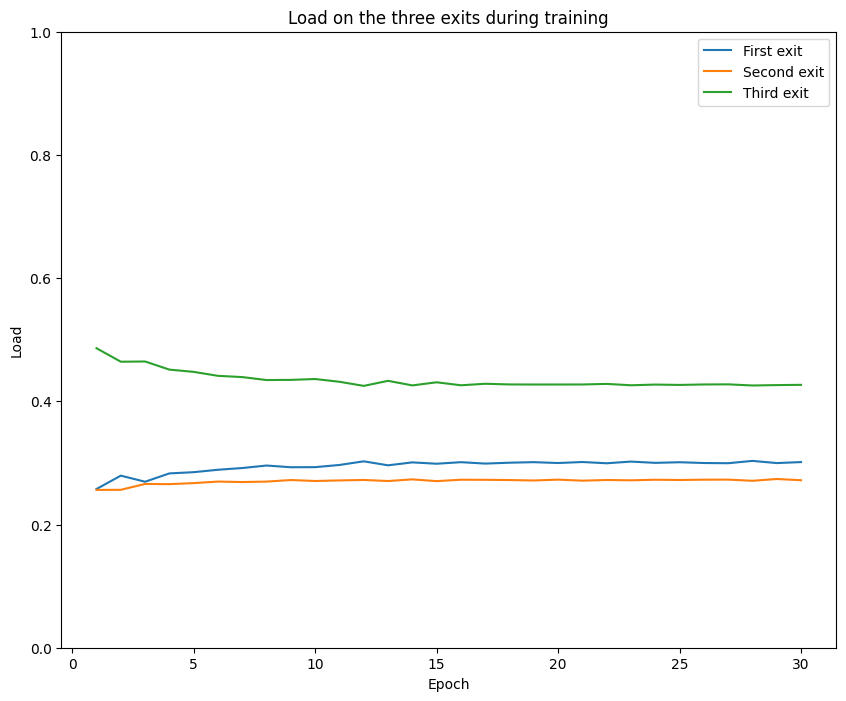

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(x, mean_prob_train_1, label='First exit')
plt.plot(x, mean_prob_train_2, label='Second exit')
plt.plot(x, mean_prob_train_3, label='Third exit')

plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Load')
plt.title('Load on the three exits during training')
plt.legend()
plt.show()

Since, as I wrote in the description of the model, at the time of inference we use an argmax applied to $p_i$, it is enough that one of the three output probabilities is even one decimal place greater than the others to be chosen. We therefore have to take these results with a grain of salt, but in any case we can see that there is no strong prevalence of one output over another.

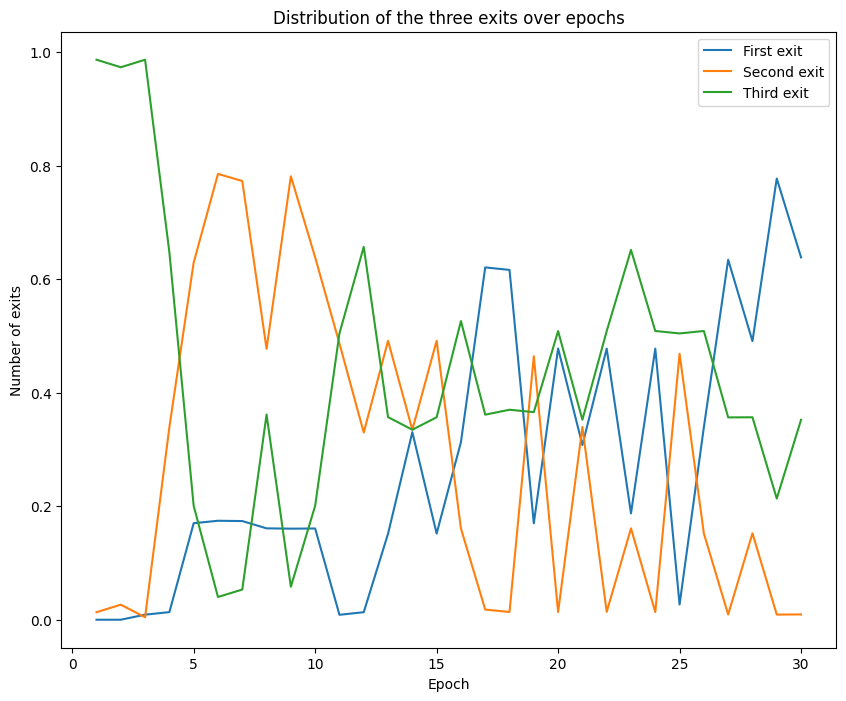

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(x, n_exit_1, label='First exit')
plt.plot(x, n_exit_2, label='Second exit')
plt.plot(x, n_exit_3, label='Third exit')

plt.xlabel('Epoch')
plt.ylabel('Number of exits')
plt.title('Distribution of the three exits over epochs')
plt.legend()
plt.show()

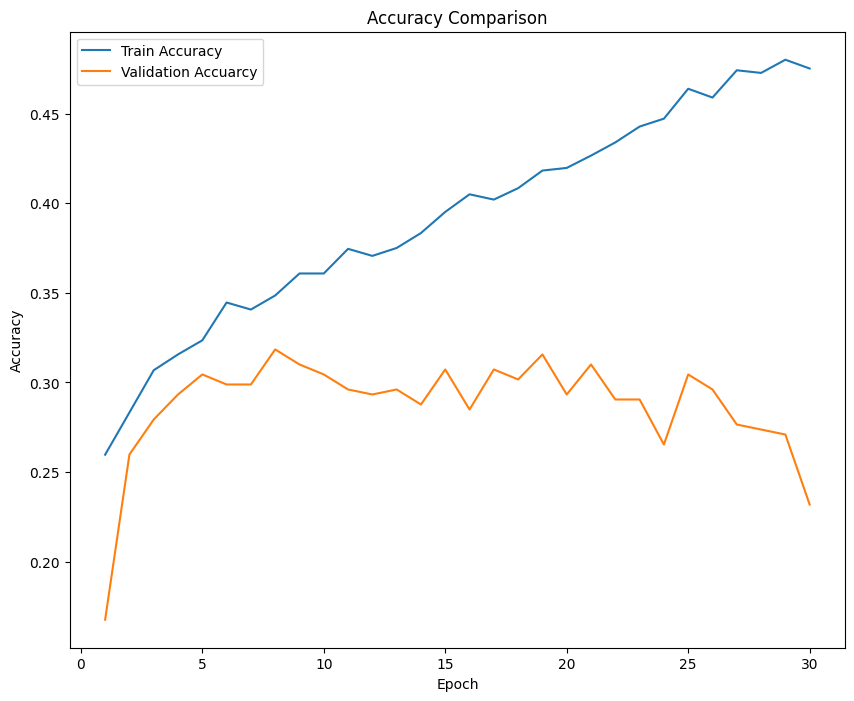

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), train_accuracy_epochs_m2, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs_m2, label='Validation Accuarcy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

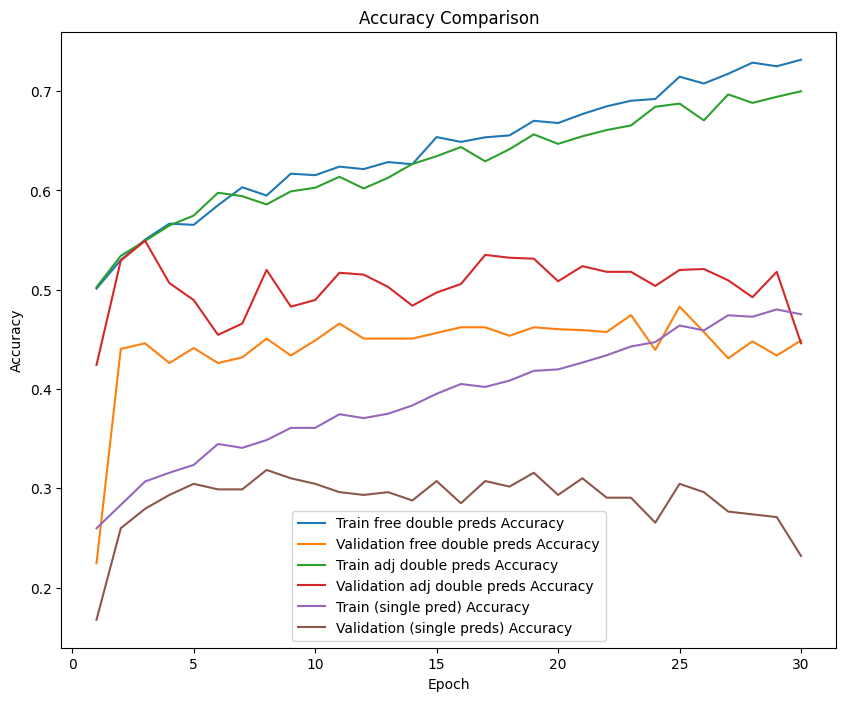

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_free_double_preds_acc_m2, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_free_double_preds_acc_m2, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_dj_double_preds_acc_m2, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_dj_double_preds_acc_m2, label='Validation adj double preds Accuracy')

plt.plot(range(1, 31), train_accuracy_epochs_m2, label='Train (single pred) Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs_m2, label='Validation (single preds) Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

# Model 4: CNN + Modularity (Early exit) (data augmentation)

In [ ]:
# let's initialize
model_balanced = Cnn_Ee_balanced(num_classes=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
train_accuracy = tf.keras.metrics.Accuracy()
val_accuracy = tf.keras.metrics.Accuracy()

# save the best model by val accuracy
stored_val_acc_M2 = 0
stored_model2 = None

In [ ]:
import time
epochs = 30

# outputs of train time
train_Total_loss_epochs = []
train_loss_epochs_preds = []
train_loss_epochs_distr= []

train_accuracy_epochs_m2 = []
train_free_double_preds_acc_m2 =[]
train_dj_double_preds_acc_m2 = []


mean_prob_train_1 = []
mean_prob_train_2 = []
mean_prob_train_3 = []

# outputs of validation time
val_Total_loss_epochs = []
val_loss_epochs_preds = []
val_loss_epochs_distr= []

n_exit_1 = []
n_exit_2 = []
n_exit_3 = []


val_accuracy_epochs_m2 = []
val_free_double_preds_acc_m2 =[]
val_dj_double_preds_acc_m2 = []


start_time = time.time()
for epoch in range(epochs):
    print("\nEpoch %d/%d" % (epoch + 1, epochs))

    # lists for intermediate results
    total_loss_intra_epoch =[]
    loss_predictions_intra_epoch =[]
    loss_distr_intra_epoch=[]
    mean_distribution_probs_intra_epoch = []
    train_acc_intra_epoch =[]

    free_double_preds_intra_epochs =[]
    adj_double_preds_intra_epochs = []

    ##############
    ##############
    ## TRAINING ##
    ##############
    ##############

    for  x_train, y_train in train_dataset_p_aug:

        with tf.GradientTape() as tape:

            predictions, probs = model_balanced(x_train, training=True)

            # Compute the loss value for this minibatch.

            ###################
            # prediction loss #
            ###################
            loss_ = tf.keras.losses.CategoricalCrossentropy()
            loss_avg_exits = loss_(y_train, predictions)
            loss_preds= tf.math.reduce_sum(loss_avg_exits)

            #####################
            # distribution loss #
            #####################
            mean_distr = tf.reduce_mean(probs, axis=0)
            mean_distribution_probs_intra_epoch.append(mean_distr)

            # the target distribution
            target_distr = tf.constant([0.333333, 0.333333, 0.333333])

            loss_distr = tf.keras.losses.KLDivergence()
            loss_avg_distr = tf.math.reduce_sum(loss_distr(target_distr,mean_distr))

            ##############
            # TOTAL LOSS #
            ##############
            total_loss = loss_preds + loss_avg_distr

            # append the intermediate results
            total_loss_intra_epoch.append(total_loss.numpy())
            loss_predictions_intra_epoch.append(loss_preds.numpy())
            loss_distr_intra_epoch.append(loss_avg_distr.numpy())

        grads = tape.gradient(total_loss, model_balanced.trainable_weights)
        optimizer.apply_gradients(zip(grads, model_balanced.trainable_weights))

        # Accuracy
        train_accuracy.update_state(tf.argmax(y_train, axis=1), tf.argmax(predictions, axis=1))

        # free double predictions accuracy
        free_double_preds = accuarcy_free_double_preds(y_train, predictions)
        free_double_preds_intra_epochs.append(free_double_preds)

        # adjacent double predictions accuracy
        adj_double_preds = accuracy_adj_double_preds(y_train, predictions)
        adj_double_preds_intra_epochs.append(adj_double_preds)

    # mean load of each exit
    mean_probs = [mean_list(pos) for pos in zip(*mean_distribution_probs_intra_epoch)]

    mean_prob_train_1.append(mean_probs[0])
    mean_prob_train_2.append(mean_probs[1])
    mean_prob_train_3.append(mean_probs[2])

    # mean loss for each type of loss
    print_total_loss = mean_list(total_loss_intra_epoch)
    print_loss_preds = mean_list(loss_predictions_intra_epoch)
    print_loss_distr= mean_list(loss_distr_intra_epoch)

    train_Total_loss_epochs.append(print_total_loss)
    train_loss_epochs_preds.append(print_loss_preds)
    train_loss_epochs_distr.append(print_loss_distr)

    print_train_accuracy = train_accuracy.result().numpy()
    train_accuracy_epochs_m2.append(print_train_accuracy)






    print("###################################  TRAIN  ###################################")
    print("Total_Loss: %.4f - loss_predictions: %.4f - loss_selection_exits: %.4f " %  (print_total_loss ,print_loss_preds , print_loss_distr))
    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (print_train_accuracy, mean_list(free_double_preds_intra_epochs), mean_list(adj_double_preds_intra_epochs)))
    print("Mean Load of each exit :  Exit_1: %.4f - Exit_2 : %.4f - All_the_layers : %.4f" % (mean_probs[0] ,mean_probs[1] , mean_probs[2] ))


    train_free_double_preds_acc_m2.append(mean_list(free_double_preds_intra_epochs))
    train_dj_double_preds_acc_m2.append(mean_list(adj_double_preds_intra_epochs))


    train_accuracy.reset_states()


    ##################
    ##################
    ### Validation ###
    ##################
    ##################


    # lists for intermediate results
    final_distribution_exits = []
    val_total_loss_intra_epoch = []
    val_loss_predictions_intra_epoch =[]
    val_loss_distr_intra_epoch = []

    val_free_double_preds_intra_epochs=[]
    val_adj_double_preds_intra_epochs=[]

    for  x_val, y_val in validation_dataset_p:
      val_predictions, distr = model_balanced(x_val, training = False)
      val_accuracy.update_state(tf.argmax(y_val, axis=1), tf.argmax(val_predictions, axis=1))

      ####################
      # loss computation #
      ####################

      # preds loss #
      CE_val =  tf.keras.losses.CategoricalCrossentropy()
      loss_CE = CE_val(y_val, val_predictions)
      val_loss_preds = tf.math.reduce_sum(loss_CE)

      # distr loss #
      total_sum = sum(distr)
      val_mean_distr = tf.constant([val/total_sum for val in distr], dtype=tf.float32)
      val_target_distr = tf.constant([0.333333, 0.333333, 0.333333])
      val_loss_distr = tf.keras.losses.KLDivergence()
      val_loss_avg_distr = tf.math.reduce_sum(val_loss_distr(val_target_distr,val_mean_distr))

      # total loss #
      val_total_loss = val_loss_preds + val_loss_avg_distr
      val_total_loss_intra_epoch.append(val_total_loss.numpy())
      val_loss_predictions_intra_epoch.append(val_loss_preds.numpy())
      val_loss_distr_intra_epoch.append(val_loss_avg_distr.numpy())


      # obtain the distribution of exits
      if not final_distribution_exits:
        final_distribution_exits = distr
      else:
        # sum
        final_exits = [a + b for a, b in zip(final_distribution_exits, distr)]
        # normalize
        final_distribution_exits = [i/sum(final_exits) for i in final_exits]

        # classic_accuarcy
        current_val_accuracy=  val_accuracy.result()

        # free double predictions accuracy
        val_free_double_preds = accuarcy_free_double_preds(y_val, val_predictions)
        val_free_double_preds_intra_epochs.append(val_free_double_preds)

        # adjacent double predictions accuracy
        val_adj_double_preds = accuracy_adj_double_preds(y_val, val_predictions)
        val_adj_double_preds_intra_epochs.append(val_adj_double_preds)



    # mean loss for each type of loss
    print_val_total_loss = mean_list(val_total_loss_intra_epoch)
    print_val_loss_preds = mean_list(val_loss_predictions_intra_epoch)
    print_val_loss_distr= mean_list(val_loss_distr_intra_epoch)

    val_Total_loss_epochs.append(print_val_total_loss)
    val_loss_epochs_preds.append(print_val_loss_preds)
    val_loss_epochs_distr.append(print_val_loss_distr)




    n_exit_1.append(final_distribution_exits[0])
    n_exit_2.append(final_distribution_exits[1])
    n_exit_3.append(final_distribution_exits[2])

    print("###################################  VALIDATION  ###################################")
    #print("Total_Loss: %.4f - loss_predictions: %.4f - loss_distribution_exits: %.4f " % (print_val_total_loss, print_val_loss_preds, print_val_loss_distr))
    #print("Accuracy : %.4f" % (current_val_accuracy))

    print("Accuracy: %.4f Accuracy_free_double: %.4f Accuracy_adj_double: %.4f" % (current_val_accuracy, mean_list(val_free_double_preds_intra_epochs), mean_list(val_adj_double_preds_intra_epochs)))
    print("Distribution of the exits :  Exit_1 : %.4f - Exit_2 : %.4f -All_the_layers: %.4f" %  (final_distribution_exits[0] ,final_distribution_exits[1] , final_distribution_exits[2]))

    # store the metrics
    val_free_double_preds_acc_m2.append(mean_list(val_free_double_preds_intra_epochs))
    val_dj_double_preds_acc_m2.append(mean_list(val_adj_double_preds_intra_epochs))
    val_accuracy_epochs_m2.append(current_val_accuracy)

    # save the best model according to validation accuracy
    if(current_val_accuracy >= stored_val_acc_M2):
     stored_val_acc_M2 = current_val_accuracy
     stored_model2 = model_balanced

    # reset metric state
    val_accuracy.reset_states()

# print execution time
print("Total time: %s seconds" % (time.time() - start_time))


Epoch 1/30
###################################  TRAIN  ###################################
Total_Loss: 1.2979 - loss_predictions: 1.2291 - loss_selection_exits: 0.0687 
Accuracy: 0.4759 Accuracy_free_double: 0.7329 Accuracy_adj_double: 0.6765
Mean Load of each exit :  Exit_1: 0.3082 - Exit_2 : 0.2456 - All_the_layers : 0.4463
###################################  VALIDATION  ###################################
Accuracy: 0.2514 Accuracy_free_double: 0.5294 Accuracy_adj_double: 0.5180
Distribution of the exits :  Exit_1 : 0.0045 - Exit_2 : 0.0135 -All_the_layers: 0.9820

Epoch 2/30
###################################  TRAIN  ###################################
Total_Loss: 1.2455 - loss_predictions: 1.1914 - loss_selection_exits: 0.0541 
Accuracy: 0.5052 Accuracy_free_double: 0.7473 Accuracy_adj_double: 0.6926
Mean Load of each exit :  Exit_1: 0.3084 - Exit_2 : 0.2406 - All_the_layers : 0.4510
###################################  VALIDATION  ###################################
Accuracy: 0

In [ ]:
# store the best model
stored_model2.save_weights('Front_dataset/Cnn_earlyexit_aug')

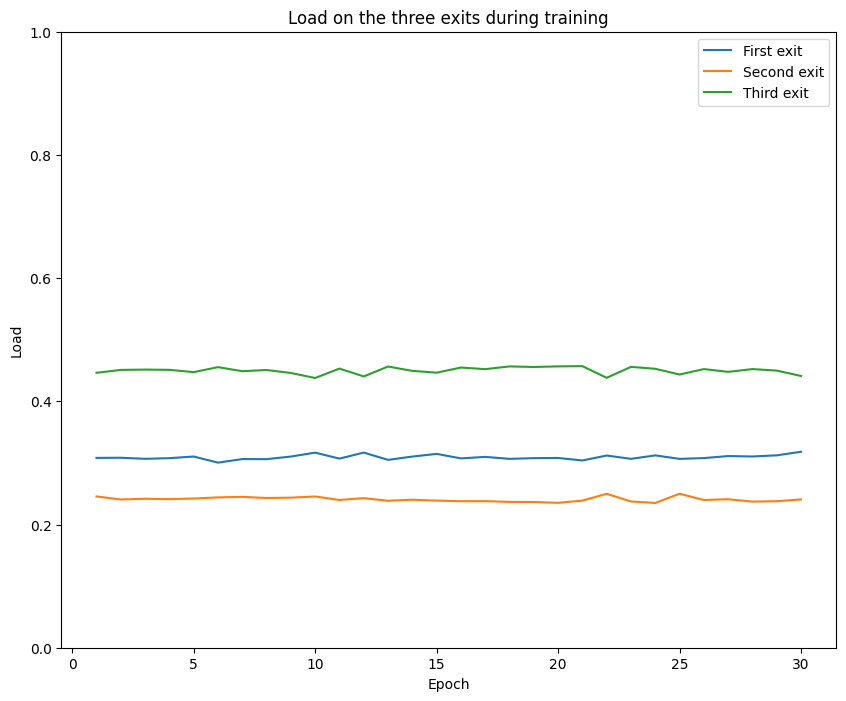

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(x, mean_prob_train_1, label='First exit')
plt.plot(x, mean_prob_train_2, label='Second exit')
plt.plot(x, mean_prob_train_3, label='Third exit')

plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Load')
plt.title('Load on the three exits during training')
plt.legend()
plt.show()

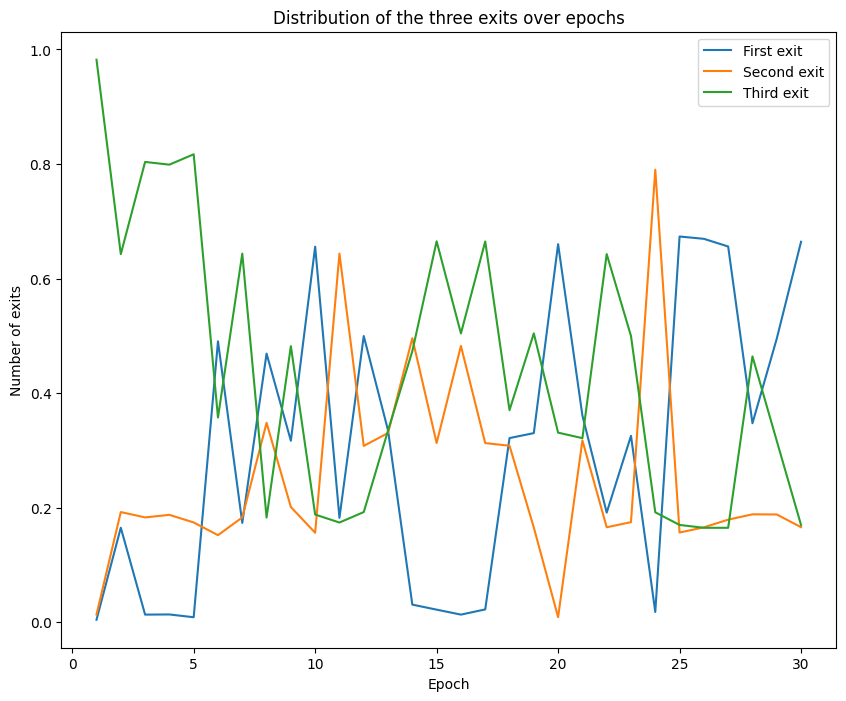

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(x, n_exit_1, label='First exit')
plt.plot(x, n_exit_2, label='Second exit')
plt.plot(x, n_exit_3, label='Third exit')

plt.xlabel('Epoch')
plt.ylabel('Number of exits')
plt.title('Distribution of the three exits over epochs')
plt.legend()
plt.show()

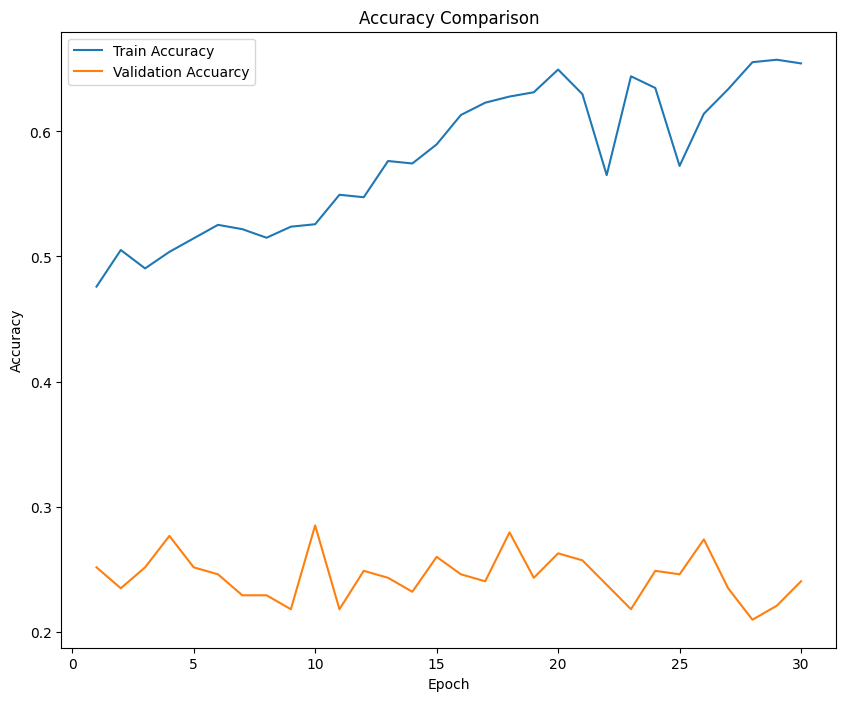

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 31), train_accuracy_epochs_m2, label='Train Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs_m2, label='Validation Accuarcy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()
plt.show()

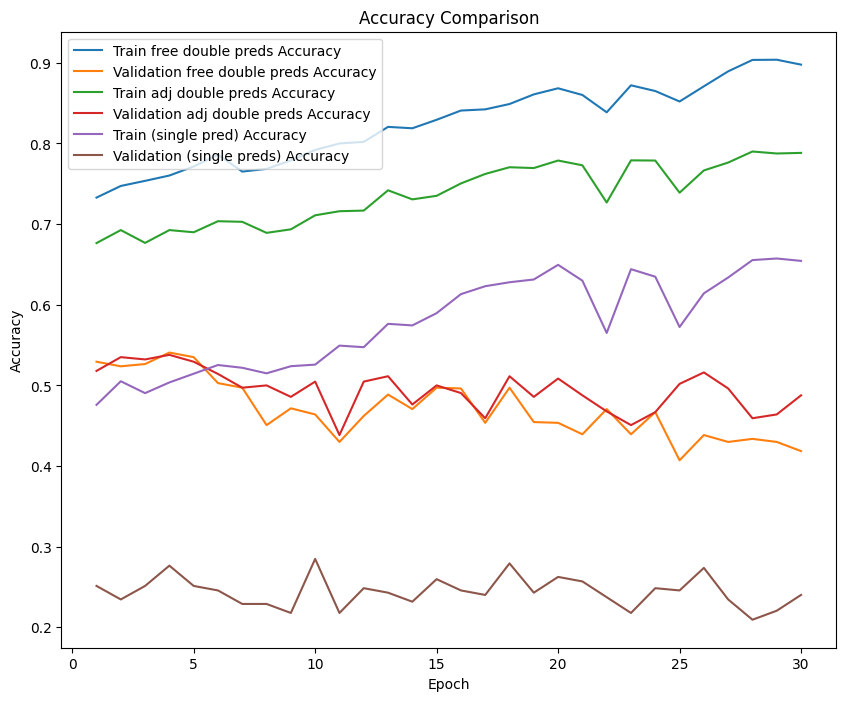

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_free_double_preds_acc_m2, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_free_double_preds_acc_m2, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_dj_double_preds_acc_m2, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_dj_double_preds_acc_m2, label='Validation adj double preds Accuracy')

plt.plot(range(1, 31), train_accuracy_epochs_m2, label='Train (single pred) Accuracy')
plt.plot(range(1, 31), val_accuracy_epochs_m2, label='Validation (single preds) Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

# Model 5: MobileNet_V2 Finetuned

MobileNetV2: Inverted Residuals and Linear Bottlenecks: https://arxiv.org/abs/1905.02244

In [ ]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf

In [ ]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=os.cpu_count()
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


def use_GPU():
    """ This function activates the gpu
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(torch.cuda.get_device_name(0), "is available and being used")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU instead")
    return device

In [ ]:
device = use_GPU()

NVIDIA GeForce RTX 4080 is available and being used


In [ ]:
train_dir = 'C:\\Users\\Alessandro\\Downloads\\Front_dataset_v2-20230911T083732Z-001\\Front_dataset_v2\\Train'
test_dir = 'C:\\Users\\Alessandro\\Downloads\\Front_dataset_v2-20230911T083732Z-001\\Front_dataset_v2\\Test'

In [ ]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
BATCH_SIZE = 16

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x23e0ba0bfd0>,
 ['0_Soft', '1_Semi_Medium', '2_Medium', '3_Semi_Hard', '4_Hard'])

In [ ]:
model = models.mobilenet_v2(pretrained=True)
model=model.to(device)

c:\Users\Alessandro\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alessandro\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_classes = 5
model.classifier[1] = torch.nn.Linear(1280, num_classes)


In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
def mean_list(lista):
  """ it computes the mean of a list
  """
  mean = sum(lista) / len(lista)
  return mean

In [ ]:
def accuracy_adj_double_preds(labels, outputs):

    _, predicted = torch.max(outputs, 1)
    correct = 0
    total = labels.size(0)
    for i in range(total):

        max_prob, max_class = torch.max(outputs[i], 0)

        if max_class == 0:
            adjacent_class = max_class + 1
        else:
            adjacent_class = max_class - 1

        if labels[i] == max_class or labels[i] == adjacent_class:
            correct += 1

    accuracy = correct / total
    return accuracy

def accuracy_free_double_preds(labels, outputs):

    _, predicted = torch.max(outputs, 1)
    correct = 0
    total = labels.size(0)
    for i in range(total):

        top_two_probs, top_two_classes = torch.topk(outputs[i], 2)
        if labels[i] in top_two_classes:
            correct += 1
    accuracy = correct / total
    return accuracy

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

# Sets the path where the model parameters will be stored.
model_path_ = r'C:\\Users\\Alessandro\\Desktop\\mobilenetv2_weights.pth'

In [ ]:
num_epochs = 30
best_val_accuracy = 0

train_loss =[]
train_accuracy =[]
train_doublefree_accuracy =[]
train_doubleadj_accuracy =[]

val_loss =[]
val_accuracy =[]
val_doublefree_accuracy =[]
val_doubleadj_accuracy =[]

for epoch in range(num_epochs):

    total_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    # Training loop
    model.train()


    free_double_preds_intra_epochs =[]
    adj_double_preds_intra_epochs = []


    for images, labels in train_dataloader:

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

        # Accumulate loss
        total_loss += loss.item()

        # free double predictions accuracy
        free_double_preds = accuracy_free_double_preds(labels, outputs)
        free_double_preds_intra_epochs.append(free_double_preds)

        # adjacent double predictions accuracy
        adj_double_preds = accuracy_adj_double_preds(labels, outputs)
        adj_double_preds_intra_epochs.append(adj_double_preds)


    # Calculate and print accuracy for the epoch
    epoch_train_loss = total_loss / len(train_dataloader)
    epoch_train_accuracy = correct_train_predictions / total_train_samples



    # store the results
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    train_doublefree_accuracy.append(mean_list(free_double_preds_intra_epochs))
    train_doubleadj_accuracy.append(mean_list(adj_double_preds_intra_epochs))




    # Validation loop

    val_free_double_preds_intra_epochs =[]
    val_adj_double_preds_intra_epochs = []

    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

            # Accumulate validation loss
            total_val_loss += loss.item()


            # free double predictions accuracy
            val_free_double_preds = accuracy_free_double_preds(labels, outputs)
            val_free_double_preds_intra_epochs.append(val_free_double_preds)

            # adjacent double predictions accuracy
            val_adj_double_preds = accuracy_adj_double_preds(labels, outputs)
            val_adj_double_preds_intra_epochs.append(val_adj_double_preds)

    # Calculate and print validation accuracy for the epoch
    epoch_val_loss = total_val_loss / len(test_dataloader)
    epoch_val_accuracy = correct_val_predictions / total_val_samples


    # store the results
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)
    val_doublefree_accuracy.append(mean_list(val_free_double_preds_intra_epochs))
    val_doubleadj_accuracy.append(mean_list(val_adj_double_preds_intra_epochs))



    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), model_path_)


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.4f}, Train Free Double Acc: {mean_list(free_double_preds_intra_epochs):.4f}, Train Adj Double Acc: {mean_list(adj_double_preds_intra_epochs):.4f},  '
          f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}, Val Free Double Acc: {mean_list(val_free_double_preds_intra_epochs):.4f}, Val Adj Double Acc: {mean_list(val_adj_double_preds_intra_epochs):.4f} ')

Epoch [1/30], Training Loss: 1.7854, Training Accuracy: 0.2823, Train Free Double Acc: 0.5067, Train Adj Double Acc: 0.4968,  Validation Loss: 1.6678, Validation Accuracy: 0.2765, Val Free Double Acc: 0.4701, Val Adj Double Acc: 0.4538 
Epoch [2/30], Training Loss: 1.5057, Training Accuracy: 0.3230, Train Free Double Acc: 0.5549, Train Adj Double Acc: 0.5275,  Validation Loss: 1.5051, Validation Accuracy: 0.3156, Val Free Double Acc: 0.5734, Val Adj Double Acc: 0.5245 
Epoch [3/30], Training Loss: 1.4902, Training Accuracy: 0.3353, Train Free Double Acc: 0.5794, Train Adj Double Acc: 0.5326,  Validation Loss: 1.5243, Validation Accuracy: 0.3296, Val Free Double Acc: 0.5598, Val Adj Double Acc: 0.5598 
Epoch [4/30], Training Loss: 1.4966, Training Accuracy: 0.3274, Train Free Double Acc: 0.5786, Train Adj Double Acc: 0.5236,  Validation Loss: 1.5108, Validation Accuracy: 0.3324, Val Free Double Acc: 0.5245, Val Adj Double Acc: 0.5435 
Epoch [5/30], Training Loss: 1.4959, Training Accura

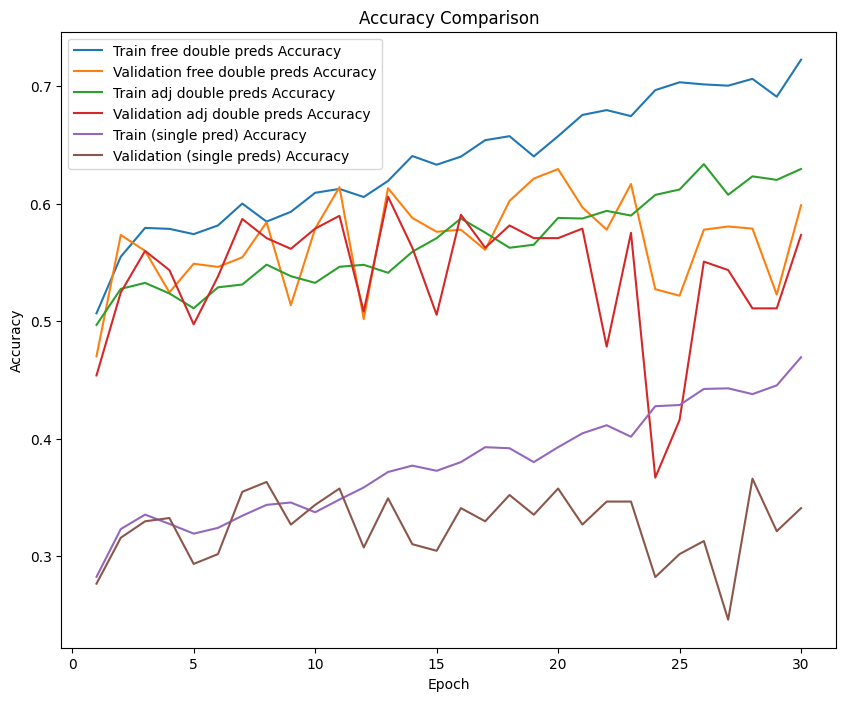

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))



plt.plot(range(1, 31), train_doublefree_accuracy, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_doublefree_accuracy, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_doubleadj_accuracy, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_doubleadj_accuracy, label='Validation adj double preds Accuracy')

plt.plot(range(1, 31), train_accuracy, label='Train (single pred) Accuracy')
plt.plot(range(1, 31), val_accuracy, label='Validation (single preds) Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')

plt.legend()
plt.show()

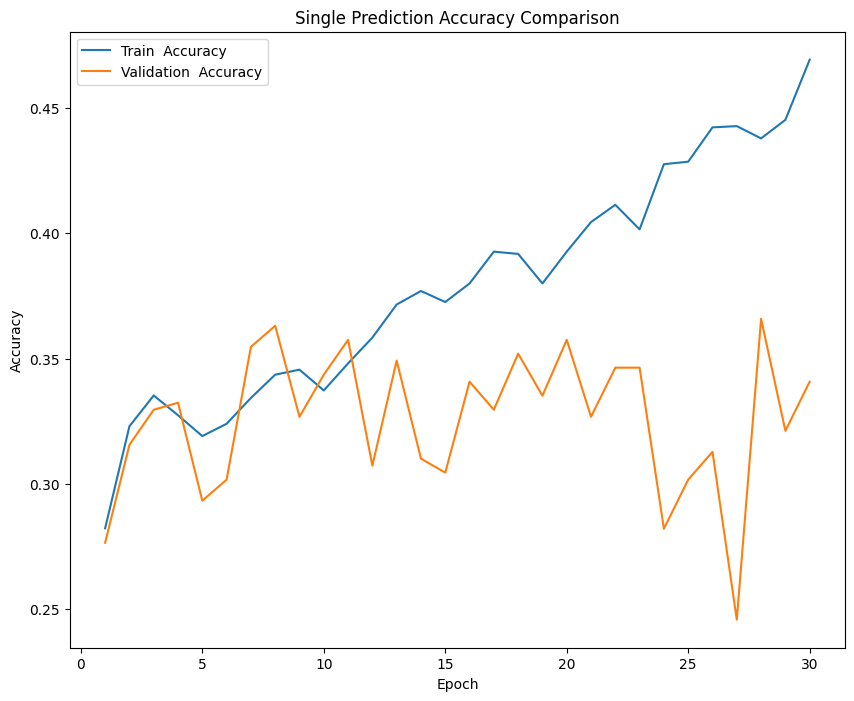

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))


plt.plot(range(1, 31), train_accuracy, label='Train  Accuracy')
plt.plot(range(1, 31), val_accuracy, label='Validation  Accuracy')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Single Prediction Accuracy Comparison')

plt.legend()
plt.show()

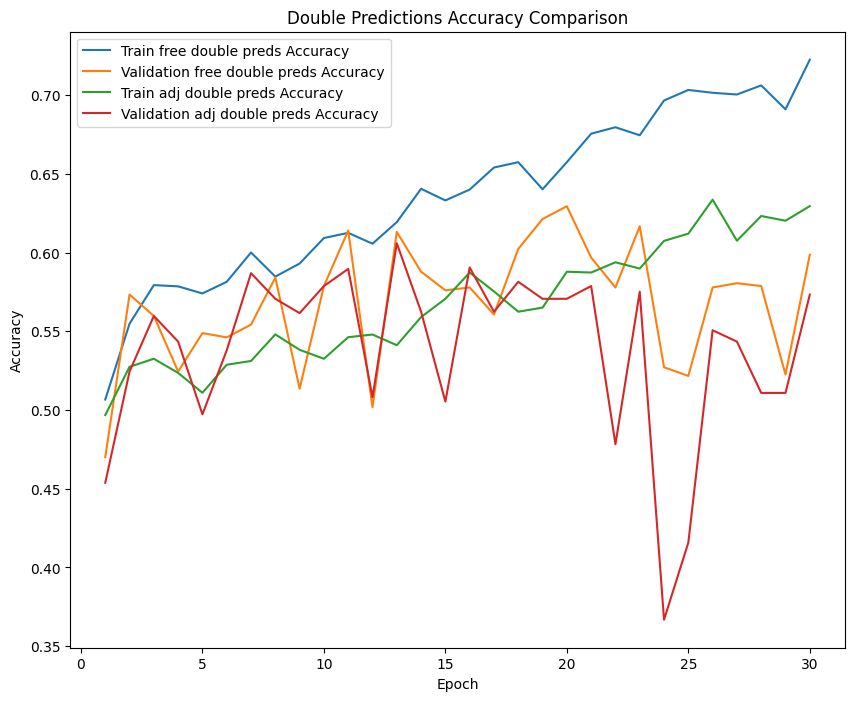

In [ ]:
x = range(1, 31)
plt.figure(figsize=(10, 8))


plt.plot(range(1, 31), train_doublefree_accuracy, label='Train free double preds Accuracy')
plt.plot(range(1, 31), val_doublefree_accuracy, label='Validation free double preds Accuracy')

plt.plot(range(1, 31), train_doubleadj_accuracy, label='Train adj double preds Accuracy')
plt.plot(range(1, 31), val_doubleadj_accuracy, label='Validation adj double preds Accuracy')



plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Double Predictions Accuracy Comparison')

plt.legend()
plt.show()

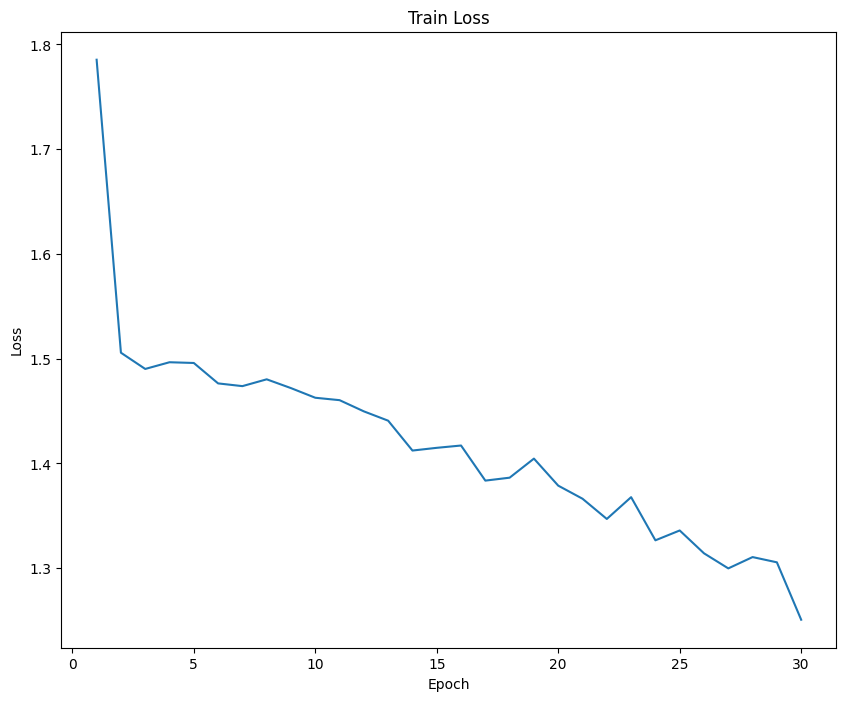

In [ ]:
x = range(1, 31)

plt.figure(figsize=(10, 8))

plt.plot(range(1, 31), train_loss)


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')


plt.show()